# Capstone project - Brain tumour classification


## Image processing

References:
 - Scarpace, Lisa, Flanders, Adam E., Jain, Rajan, Mikkelsen, Tom, & Andrews, David W. (2015). Data From REMBRANDT. The Cancer Imaging Archive. http://doi.org/10.7937/K9/TCIA.2015.588OZUZB  
 - Clark K, Vendt B, Smith K, Freymann J, Kirby J, Koppel P, Moore S, Phillips S, Maffitt D, Pringle M, Tarbox L, Prior F. The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository, Journal of Digital Imaging, Volume 26, Number 6, December, 2013, pp 1045-1057.
 - PyScience blog, https://pyscience.wordpress.com/

1. [In 2D with one sequence (T1)](#Part1)   
    a. [First option: dicom library & skimage](#Part1a)  
      i. [Tumour isolation with edge detection](#Part1ai)  
      ii. [Tumour isolation with region-based segmentation](#Part1aii)  
    b. [Second option: SimpleITK library](#Part1b)  
      i. [Tumour isloation on T1 image (using confidence connected filter with manual seed selection)](#Part1bi)  
      ii. [Tumour isloation on T2 image (using thresholding and confidence connected filter with automated seed selection from thresholding)](#Part1bii)    
          
2. [In 2D with 4 different sequences (T1, T2, FLAIR and T1 GD)](#Part2)   
   a. [Reshape images](#Part2a)  
   b. [Remove noise](#Part2b)  
   c. [Multimodal segmentation - merge T2 and FLAIR images to get a more accurate tumour delimitation](#Part2c)     
       
3. [In 3D](#Part3)   
    a. [Segmentation of tumour in each sequence](#Part3a)  
    b. [Segmentation of tumour in all four sequences combined](#Part3b)  
    c. [Segmentation of tumour in T2 and FLAIR images combined](#Part3c)  
    d. [Automate seed generation](#Part3d)   
    e. [Selection of slice with largest tumour area](#Part3e)  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline
pd.set_option("display.max_columns",101)

<a id='Part1'></a>

## 1. In 2D with one sequence (T1)

<a id='Part1a'></a>

### a. First option: dicom library & skimage

In [2]:
import dicom
from skimage import io
import os
import numpy
from matplotlib import cm

In [206]:
# Extracting scans fron the first patient

PathDicom = "../REMBRANDT/900-00-1961/AX_T1"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

In [207]:
# Get ref file
RefDs = dicom.read_file(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

In [250]:
# DICOM images characteristics
dicom.read_file(lstFilesDCM[0])

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.50.101059839858483772076354011531404942974
(0008, 0020) Study Date                          DA: '20050619'
(0008, 0023) Content Date                        DA: '20050619'
(0008, 0030) Study Time                          TM: ''
(0008, 0033) Content Time                        TM: ''
(0008, 0050) Accession Number                    SH: '1293190500624970'
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufacturer                        LO: ''
(0008, 0090) Referring Physician's Name          PN: ' '
(0008, 1032)  Procedure Code Sequence   1 item(s) ---- 

   ---------
(0010, 0010) Patient's Name                      PN: '253609'
(0010, 0020) Patient ID                        

In [209]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = numpy.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = dicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array 

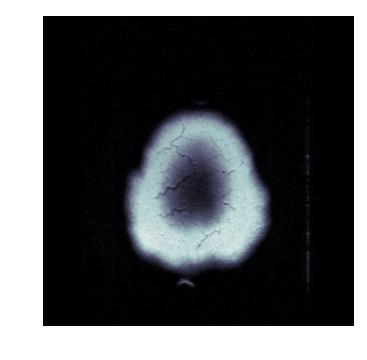

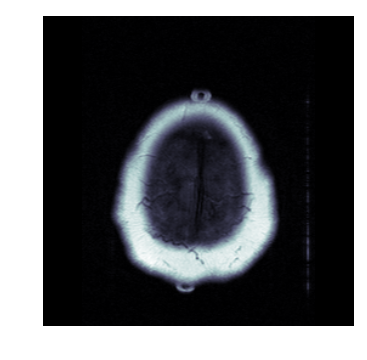

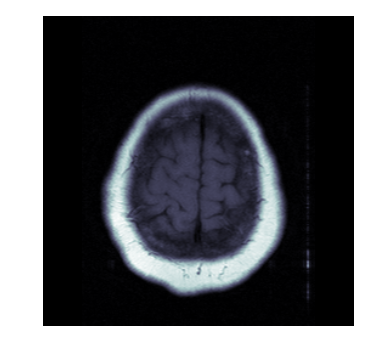

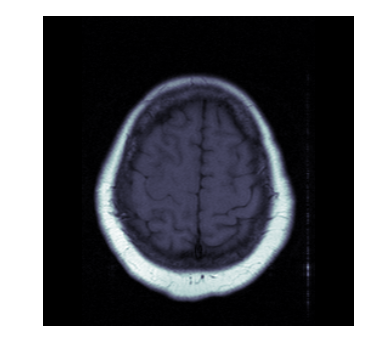

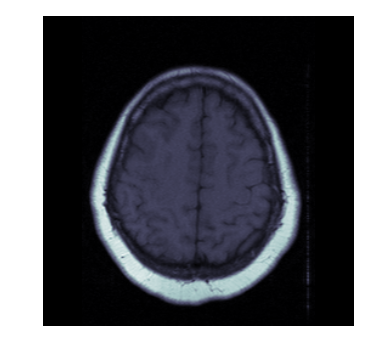

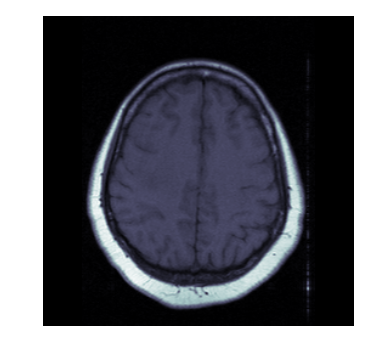

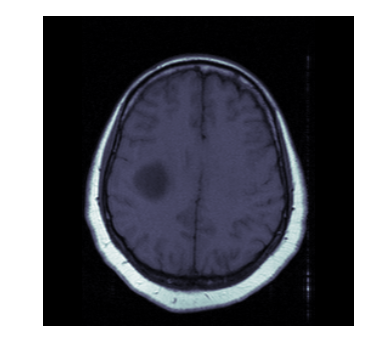

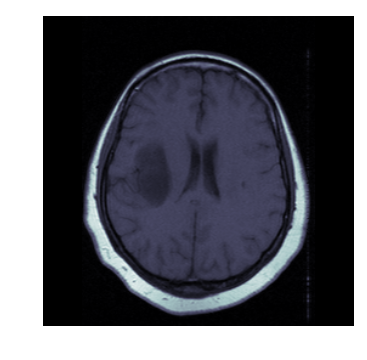

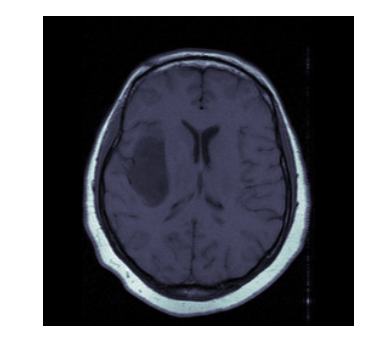

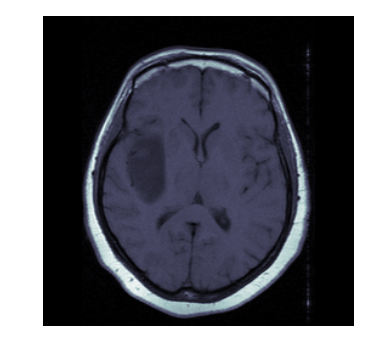

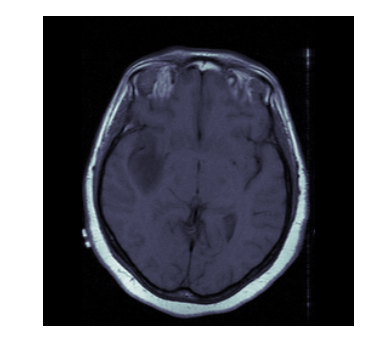

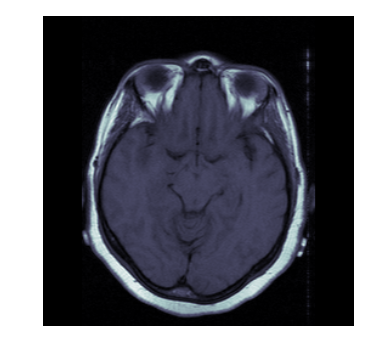

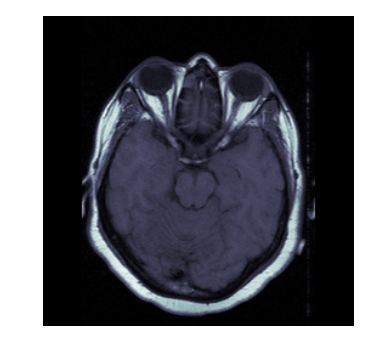

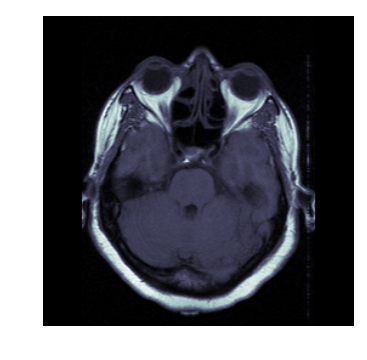

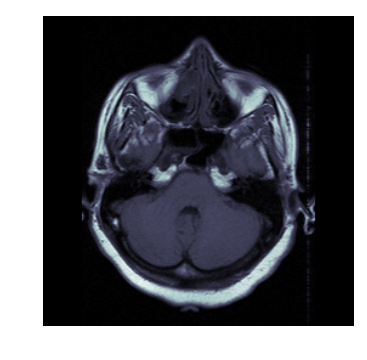

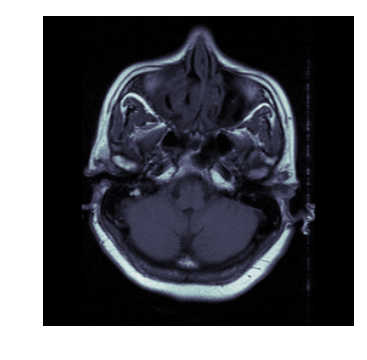

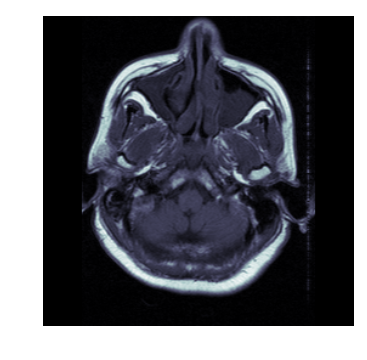

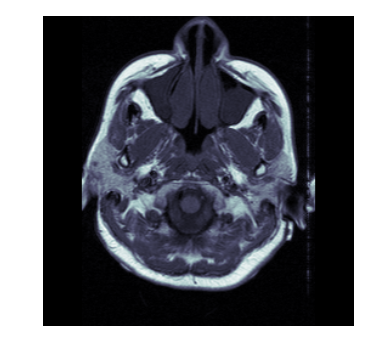

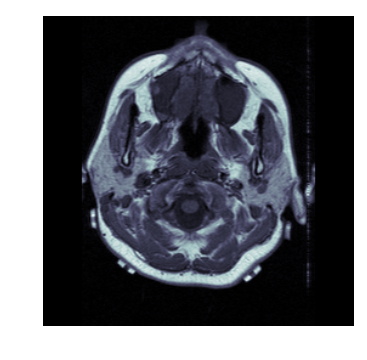

In [210]:
# Display all images in the first sequence of the first patient
import pylab

for i in range(19):
    fig, ax = plt.subplots(dpi=300)
    pylab.imshow(ArrayDicom[:, :, i], cmap=pylab.cm.bone)
    plt.axis('off')
    pylab.show()

<a id='Part1ai'></a>

#### (i) Tumour isolation with edge detection

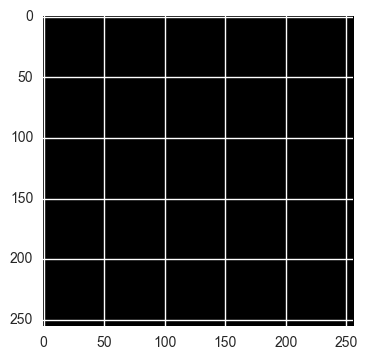

In [220]:
# Edge detection on the image itself didn't give any results

from skimage import feature

edges = feature.canny(ArrayDicom[:, :, 8], sigma=0.5)
pylab.imshow(edges, cmap=pylab.cm.bone)

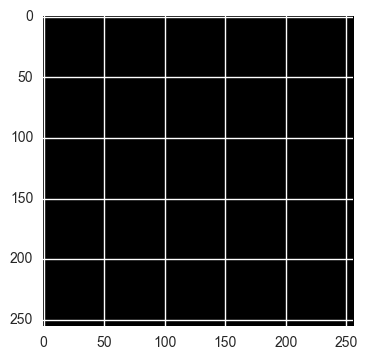

In [221]:
# Edge detection on a Gamma filtered image didn't give any results either

from skimage import exposure
gamma_corrected = exposure.adjust_gamma(ArrayDicom[:, :, 8], 1.5)

edges1 = feature.canny(gamma_corrected, sigma=0.5)
pylab.imshow(edges1, cmap=pylab.cm.bone)

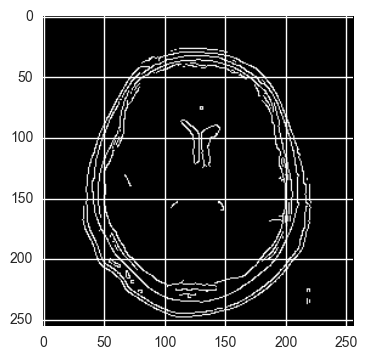

In [222]:
# Edge detection on a logarithmic filtered image wasn't able to detect the tumour
logarithmic_corrected = exposure.adjust_log(ArrayDicom[:, :, 8], 10)

edges2 = feature.canny(logarithmic_corrected, sigma=0.5)

pylab.imshow(edges2, cmap=pylab.cm.bone)

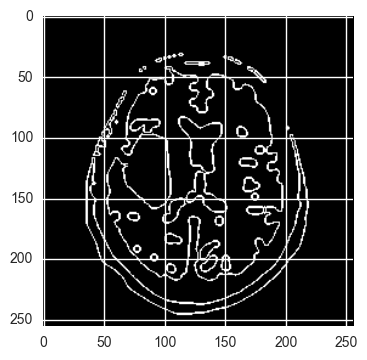

In [223]:
# Edge detection on a logarithmic filtered image with thresholding detected too much
edges3 = feature.canny(logarithmic_corrected>5500, sigma=0.5)

pylab.imshow(edges3, cmap=pylab.cm.bone)

<a id='Part1aii'></a>

#### (ii) Tumour isolation with region-based segmentation

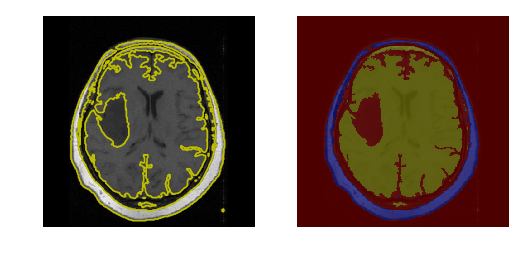

In [243]:
# Find an elevation map using the Sobel gradient of the image

from skimage.filters import sobel
elevation_map = sobel(ArrayDicom[:, :, 8])

# Find markers of the background and the brain based on the extreme parts of the histogram of grey values

markers = np.zeros_like(logarithmic_corrected)
markers[logarithmic_corrected<6000] = 1
markers[logarithmic_corrected>6500] = 2

# Use the watershed transform to fill regions of the elevation map starting from the markers determined above
from skimage import morphology
segmentation = morphology.watershed(elevation_map, markers)

from skimage.color import label2rgb
from scipy import ndimage as ndi

segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_regions, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_regions, image=logarithmic_corrected)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
ax1.imshow(logarithmic_corrected, cmap=plt.cm.gray, interpolation='nearest')
ax1.contour(segmentation, [0.5], linewidths=1.2, colors='y')
ax1.axis('off')
ax1.set_adjustable('box-forced')
ax2.imshow(image_label_overlay, interpolation='nearest')
ax2.axis('off')
ax2.set_adjustable('box-forced')

These libraries seemed more difficult to use than the next librairy which has been designed specifically for medical images visualisation and analysis. I therefore stopped using DICOM and Skimage to extract tumour features and switched to SimpleITK.

<a id='Part1b'></a>

### b. Second option: SimpleITK library

In [3]:
import SimpleITK

<a id='Part1bi'></a>

#### (i) Tumour isloation on T1 image (using confidence connected filter with manual seed selection)

In [4]:
# Load in DICOM images for 1 sequence of 1 patient

PathDicom = "../REMBRANDT/900-00-1961/AX_T1/"

reader = SimpleITK.ImageSeriesReader()
filenamesDICOM = reader.GetGDCMSeriesFileNames(PathDicom)
reader.SetFileNames(filenamesDICOM)
imgOriginal = reader.Execute()

In [5]:
# int labels to assign to the segmented tumour
labelWhiteMatter = 1
labelTumour = 2

In [6]:
# Define a function to display one ITK image

def sitk_show(img, title=None, margin=0.0, dpi=40, axis='off'):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    ax.axis(axis)
    
    if title:
        plt.title(title)
    
    plt.show()

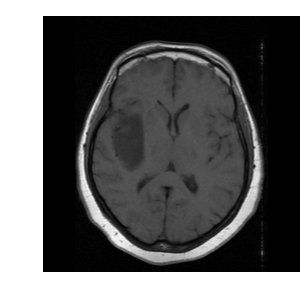

In [7]:
# View one image slice

imgSlice = imgOriginal[:,:,10]

sitk_show(imgSlice, dpi=100)

In [42]:
# Get intensity values for this image
intensity_values_T1 = SimpleITK.GetArrayFromImage(imgSlice)

plt.hist(intensity_values_T1, bins=256)
plt.title("Intensity Values T1")
plt.show()

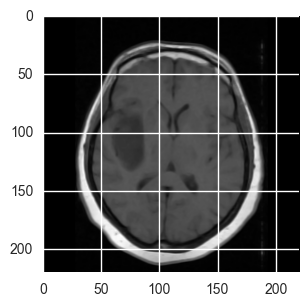

In [8]:
# Apply a curvature-flow filter to smoothen the image (get rid of image noise)

imgSmooth = SimpleITK.CurvatureFlow(image1=imgSlice,
                                    timeStep=0.125,
                                    numberOfIterations=5)

# blurFilter = SimpleITK.CurvatureFlowImageFilter()
# blurFilter.SetNumberOfIterations(5)
# blurFilter.SetTimeStep(0.125)
# imgSmooth = blurFilter.Execute(imgSlice)

sitk_show(imgSmooth, axis='on', dpi=100)

In [9]:
# Segmentation with the ConfidenceConnected filter
# What this filter does is simply “label pixels that are connected to a seed and lie within a range of values”. 
# Essentially, this filter operates on the input image starting from a series of given ‘seed points’. 
# It then starts ‘growing’ a region around those points and keeps adding the neighboring points as long as 
# their values fall within given thresholds.

# Initial segmentation of white matter

lstSeeds = [(150,110)]

imgWhiteMatter = SimpleITK.ConfidenceConnected(image1=imgSmooth, 
                                               seedList=lstSeeds,
                                               numberOfIterations=5,
                                               multiplier=3,
                                               replaceValue=labelWhiteMatter)

imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter), dpi=100)

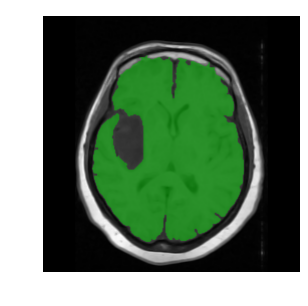

In [10]:
# Fill holes in the white matter label through BinaryClosingByReconstruction

imgWhiteMatterNoHoles = SimpleITK.BinaryClosingByReconstruction(imgWhiteMatter, 10)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatterNoHoles), dpi=100)

In [11]:
# Segmentation of tumour

lstSeeds = [(80, 120), (70, 130)]

imgTumour = SimpleITK.ConfidenceConnected(image1=imgSmooth, 
                                              seedList=lstSeeds,
                                              numberOfIterations=3,
                                              multiplier=1.75,
                                              replaceValue=labelTumour)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgTumour), axis='on', dpi=100)

In [12]:
imgSmooth.GetPixelIDTypeAsString()

'64-bit float'

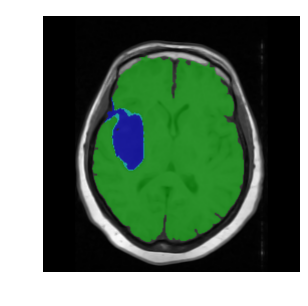

In [25]:
# Bitwire OR combination of the white matter and gray matter labels

imgLabels = imgWhiteMatterNoHoles | imgTumour


sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels), dpi=100)

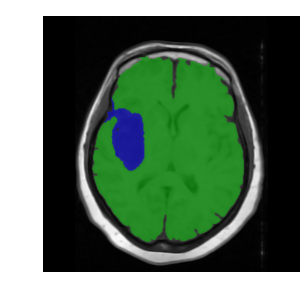

In [26]:
# Assignment of common areas to the tumour

imgMask = (imgWhiteMatterNoHoles / labelWhiteMatter) * (imgTumour / labelTumour)
imgWhiteMatterNoHoles -= imgMask*labelWhiteMatter

imgLabels = imgWhiteMatterNoHoles + imgTumour

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels), dpi=100)

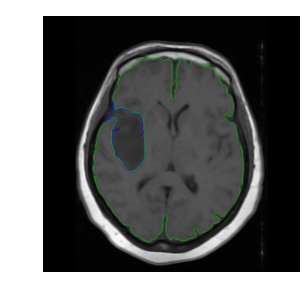

In [27]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, SimpleITK.LabelContour(imgLabels)), axis='off', dpi=100)

In [28]:
# Estimate the tumour radius from the segmented image using the LabelShapeStatisticsImageFilter.
label_shape_analysis = SimpleITK.LabelShapeStatisticsImageFilter()
label_shape_analysis.SetBackgroundValue(1)
label_shape_analysis.Execute(imgTumour)
print("The tumour's radius is: {0:.2f}mm".format(label_shape_analysis.GetEquivalentSphericalRadius(labelTumour)))

The tumour's radius is: 19.64mm


In [29]:
# Tumour center location out of 256x256 pixels 
# Assign to 3 if left (ie [0] > 128), 1 if right - HOW TO CHECK IF BILATERAL??
# CAREFUL : this is the side of the brain so will appear opposite on image!

imgTumour.TransformPhysicalPointToIndex(label_shape_analysis.GetCentroid(labelTumour))

(84L, 121L)

In [30]:
# = f29 & f30
# Assign labels from 0 to 18 to closest size and insert in df

label_shape_analysis.GetEquivalentEllipsoidDiameter(labelTumour)

(28.13750164523707, 54.84014536501314)

In [31]:
# Will be needed to compute proportions
label_shape_analysis.GetNumberOfPixels(2)

1641L

<a id='Part1bii'></a>

#### (ii) Tumour isloation on T2 image (using thresholding and confidence connected filter with automated seed selection from thresholding)

In [38]:
# Read-in T2 sequence
PathDicom = "../REMBRANDT/900-00-1961/AX_T2/"

reader_T2 = SimpleITK.ImageSeriesReader()
filenamesDICOM_T2 = reader_T2.GetGDCMSeriesFileNames(PathDicom)
reader_T2.SetFileNames(filenamesDICOM_T2)
imgOriginal_T2 = reader_T2.Execute()

In [39]:
imgSlice_T2 = imgOriginal_T2[:,:,10]

print 'Original image size:', imgSlice_T2.GetSize()

# Reshape to 256x256 pixels (as T1 image)
shrinker = SimpleITK.ShrinkImageFilter()
shrinker.SetShrinkFactors([2,2,1])
imgSlice_T2 = shrinker.Execute(imgSlice_T2)

print 'Reshaped image size:', imgSlice_T2.GetSize()

sitk_show(imgSlice_T2, dpi=100)

Original image size: (512, 512)
Reshaped image size: (256, 256)


In [40]:
# Apply a curvature-flow filter to smoothen the image (get rid of image noise)

imgSmooth_T2 = SimpleITK.CurvatureFlow(image1=imgSlice_T2,
                                    timeStep=0.125,
                                    numberOfIterations=5)

##### - Apply intensity thresholding to detect basic tumour shape
(This is only possible on T2 and FLAIR images as the tumour appears bright on these images; contrary to T1 images on which it appears dark)

 - Tumour with Otsu thresholding (automatic thresholding) - does not isolate the tumour correctly

226.866317749


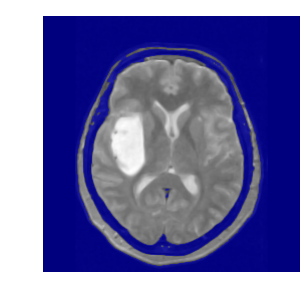

In [99]:
otsu_filter = SimpleITK.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(labelTumour)
otsu_filter.SetOutsideValue(0)
otsu_filter.SetNumberOfHistogramBins(256)

tumour_otsu = otsu_filter.Execute(imgSmooth_T2)

print otsu_filter.GetThreshold()

imgSmoothOtsu_T2 = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth_T2), tumour_otsu.GetPixelID())

sitk_show(SimpleITK.LabelOverlay(imgSmoothOtsu_T2, tumour_otsu), dpi=100)

 - Let's try manual thresholding instead

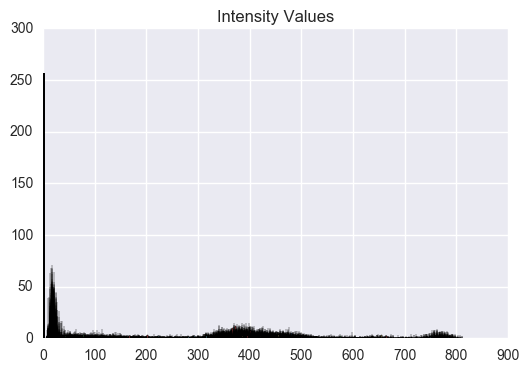

In [11]:
# Get histogram of image intensities

intensity_values_T2 = SimpleITK.GetArrayFromImage(imgSmooth_T2)

plt.hist(intensity_values_T2, bins=256)
plt.title("Intensity Values")
plt.show()

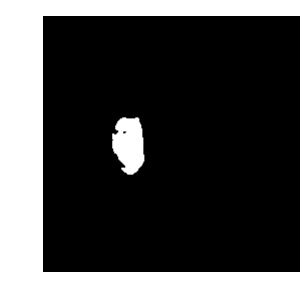

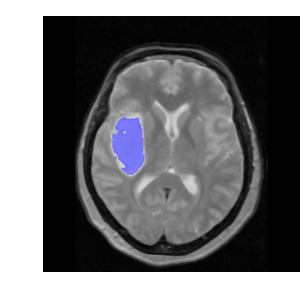

In [42]:
# Tumour segmentation with Binary Thresholding
tumour_thres = SimpleITK.BinaryThreshold(imgSmooth_T2, lowerThreshold=695, upperThreshold=900, 
                                         insideValue=labelTumour, outsideValue=0)

imgSmoothInt_T2 = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth_T2), tumour_thres.GetPixelID())

sitk_show(tumour_thres, dpi=100)
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt_T2, tumour_thres), dpi=100)

This doesn't isolate the whole tumour perfectly but it seems to be more easily reproducible for other images. We will then be able to extract seeds to compute a confidence connected automatically (without having to define the seeds manually)

##### Generate only a few seeds from calculating the tumour's parameters from the thresholding segmentation

In [61]:
# Compute LabelShapeStatisticsImageFilter to get a basic description of the tumour thresholding segmentation
label_shape_analysis_T2 = SimpleITK.LabelShapeStatisticsImageFilter()
label_shape_analysis_T2.SetBackgroundValue(0)
label_shape_analysis_T2.Execute(tumour_thres)

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x1228dfba0> >

In [62]:
# Get main parameters to find seeds

tumour_thres_centroid = label_shape_analysis_T2.GetCentroid(labelTumour)

tumour_thres_principalAxesRotation = label_shape_analysis_T2.GetPrincipalAxes(labelTumour)
cosTheta = tumour_thres_principalAxesRotation[0]

tumour_thres_EllipsoidDiameters = label_shape_analysis_T2.GetEquivalentEllipsoidDiameter(labelTumour)

# Print results
print 'Centroid:', tumour_thres_centroid

print 'Diameter along first principal axis projected on x:', tumour_thres_EllipsoidDiameters[0]*cosTheta
print 'Diameter along second principal axis projected on y:', tumour_thres_EllipsoidDiameters[1]*cosTheta

Centroid: (-31.34336409457893, 16.785521218943032)
Diameter along first principal axis projected on x: 26.1533886984
Diameter along second principal axis projected on y: 49.0573486885


In [63]:
# Get tumour bounding box to find seeds
(x0, y0, l, L) = label_shape_analysis_T2.GetBoundingBox(labelTumour)
print 'Bounding box start index and size:', (x0, y0, l, L)

# Plot bounding box
T2_box = SimpleITK.Image(imgSmoothInt_T2)

T2_box[x0,y0] = 0
    
for x in range(l):
    T2_box[x0+x,y0] = 0
    T2_box[x0+x,y0+L] = 0
    
for y in range(L):
    T2_box[x0,y0+y] = 0
    T2_box[x0+l,y0+y] = 0
    
sitk_show(T2_box, dpi=100)

Bounding box start index and size: (69, 102, 32, 57)


In [64]:
# Generate Seeds
centre = imgSmoothInt_T2.TransformPhysicalPointToIndex(tumour_thres_centroid)

seeds_auto = [centre, (centre[0], y0+1), (centre[0], y0+L-1), (x0+1, centre[1]), (x0+l-1, centre[1]),
              (x0+10, y0+10), (x0+l-10, y0+10), (x0+10, y0+L-10), (x0+l-10, y0+L-10)]

# Show seeds on the image
seeds_locs = SimpleITK.Image(imgSmoothInt_T2)
for pt in seeds_auto:
    seeds_locs[pt[0],pt[1]] = 0
    
sitk_show(seeds_locs)

##### - Or simply take the whole tumour segented with thresholding as seeds

In [81]:
seeds_auto_2 = np.argwhere(SimpleITK.GetArrayFromImage(tumour_thres)==2)

# Inverse dimensions as the function GetArryFromImage returns vertical image values in lines and horizontal image values in columns 
for seed in seeds_auto_2:
    seed[0], seed[1] = seed[1], seed[0]

# Show seeds on the image
seeds_locs_2 = SimpleITK.Image(imgSmoothInt_T2)
for pt in seeds_auto_2:
    seeds_locs_2.SetPixel(pt[0],pt[1], 0)
    
sitk_show(seeds_locs_2)

##### - Apply confidence connected filter from automatedly generated seeds to isolate the tumour

In [19]:
# Segmentation of tumour using confidence connected filter

imgTumour_T2 = SimpleITK.ConfidenceConnected(image1=imgSmoothInt_T2, 
                                              seedList=seeds_auto,
                                              numberOfIterations=3,
                                              multiplier=1.5,
                                              replaceValue=labelTumour)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt_T2, imgTumour_T2), axis='on', dpi=100)

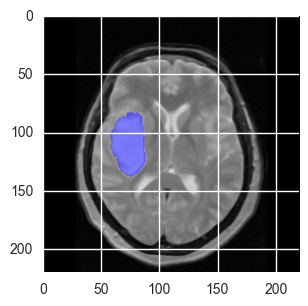

In [84]:
imgTumour_T2 = SimpleITK.ConfidenceConnected(image1=imgSmoothInt_T2, 
                                              seedList=seeds_auto_2,
                                              numberOfIterations=3,
                                              multiplier=4,
                                              replaceValue=labelTumour)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt_T2, imgTumour_T2), axis='on', dpi=100)

We get similar results if we only use a couple of points from the thresholding segmentation or if we use the whole segment. Since the second approach is much easier to implement, this is the one we will use going further.

In [32]:
# Do we get similar sizes and centres with T2 image as for T1 image?

label_shape_analysis_T2 = SimpleITK.LabelShapeStatisticsImageFilter()
label_shape_analysis_T2.SetBackgroundValue(0)
label_shape_analysis_T2.Execute(imgTumour_T2)

print 'T1 Confidence Connected dimensions'
print 'Centre location:', imgTumour.TransformPhysicalPointToIndex(label_shape_analysis.GetCentroid(labelTumour))
print 'Ellipsoid diameters:', label_shape_analysis.GetEquivalentEllipsoidDiameter(labelTumour)
print 'Number of pixels in tumour:', label_shape_analysis.GetNumberOfPixels(labelTumour)

print '-----'

print 'T2 Confidence Connected dimensions'
print 'Centre location:', imgTumour_T2.TransformPhysicalPointToIndex(label_shape_analysis_T2.GetCentroid(labelTumour))
print 'Ellipsoid diameters:', label_shape_analysis_T2.GetEquivalentEllipsoidDiameter(labelTumour)
print 'Number of pixels in tumour:', label_shape_analysis_T2.GetNumberOfPixels(labelTumour)

print '-----'
label_shape_analysis_T2.Execute(tumour_thres)
print 'T2 Thresholding dimensions'
print 'Centre location:', tumour_thres.TransformPhysicalPointToIndex(label_shape_analysis_T2.GetCentroid(labelTumour))
print 'Ellipsoid diameters:', label_shape_analysis_T2.GetEquivalentEllipsoidDiameter(labelTumour)
print 'Number of pixels in tumour:', label_shape_analysis_T2.GetNumberOfPixels(labelTumour)

T1 Confidence Connected dimensions
Centre location: (84L, 121L)
Ellipsoid diameters: (28.13750164523707, 54.84014536501314)
Number of pixels in tumour: 1641
-----
T2 Confidence Connected dimensions
Centre location: (85L, 128L)
Ellipsoid diameters: (29.202967975245166, 54.28828568805259)
Number of pixels in tumour: 1686
-----
T2 Thresholding dimensions
Centre location: (85L, 128L)
Ellipsoid diameters: (26.263883270121532, 49.264609429990266)
Number of pixels in tumour: 1376


Please note the thresholding segmentation is quite poor but should only be used to automatically generate seeds for a confidence connected filter.

<a id='Part2'></a>

## 2. In 2D with 4 different sequences (T1, T2, FLAIR and T1 GD)

In [5]:
# Define a function to display the 4 sequences

sequence_names = ['T1', 'T2', 'FLAIR', 'T1 GD']

def sitk_show_4seq(imgs, margin=0.05, dpi=40, axis='off', size=(5,5)):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=size)
        
    for ax, img, seq in zip([ax1,ax2,ax3,ax4], imgs, sequence_names):
        nda = SimpleITK.GetArrayFromImage(img)
        spacing = img.GetSpacing()
        figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
        extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)

        plt.set_cmap("gray")
        ax.imshow(nda,extent=extent,interpolation=None)
        ax.set_title(seq)
        ax.axis(axis)
    
    fig.show()

In [6]:
# Load in DICOM images for 1 patient

# Load in the 4 main sequences: T1, T2, FLAIR and post-IV (= T1 GD)
PathDicom_T1 = "../REMBRANDT/900-00-1961/AX_T1/"
PathDicom_T2 = "../REMBRANDT/900-00-1961/AX_T2/"
PathDicom_FLAIR = "../REMBRANDT/900-00-1961/AX_FLAIR/"
PathDicom_T1GD = "../REMBRANDT/900-00-1961/AX_T1_GD/"

# Load in image series
def import_img_series(path):
    reader = SimpleITK.ImageSeriesReader()
    filenamesDICOM = reader.GetGDCMSeriesFileNames(path)
    reader.SetFileNames(filenamesDICOM)
    return reader.Execute()

img_T1_Original = import_img_series(PathDicom_T1)
img_T2_Original = import_img_series(PathDicom_T2)
img_FLAIR_Original = import_img_series(PathDicom_FLAIR)
img_T1GD_Original = import_img_series(PathDicom_T1GD)

img_4seq = [img_T1_Original, img_T2_Original, img_FLAIR_Original, img_T1GD_Original]

<a id='Part2a'></a>

### a. Reshape images

#### - First approach: Shrink images to 256x256, reset paremeters and crop T1 GD image
This approach was the first I tried to reshape all images to the same dimensions. However while it allowed for images to be superimposed it didn't allow them to have the same brain orientation/size/centre/alignment. In particular T1GD image wasn't aligned at all with the other three images.

In [7]:
# As we can see images have different sizes
for seq, img in zip(sequence_names, img_4seq):
    print seq,':', img.GetSize()

T1 : (256, 256, 20)
T2 : (512, 512, 20)
FLAIR : (256, 256, 20)
T1 GD : (512, 512, 60)


In [8]:
# Resize T2 and T1GD images to 256x256 pixels
shrinker = SimpleITK.ShrinkImageFilter()
shrinker.SetShrinkFactors([2,2,1])
img_T2_Original = shrinker.Execute(img_T2_Original)
img_T1GD_Original = shrinker.Execute(img_T1GD_Original)

img_4seq = [img_T1_Original, img_T2_Original, img_FLAIR_Original, img_T1GD_Original]

for seq, img in zip(sequence_names, img_4seq):
    print seq,':', img.GetSize()

T1 : (256, 256, 20)
T2 : (256, 256, 20)
FLAIR : (256, 256, 20)
T1 GD : (256, 256, 60)


In [9]:
# Images also have slightly different origins and spacings which makes it impossible to superimpose them

print 'Origins:'
for i in img_4seq:
    print i.GetOrigin()
print '---'
print 'Spacings:'
for i in img_4seq:
    print i.GetSpacing()

Origins:
(-105.0097885131836, -92.68102264404297, -69.89035034179688)
(-104.7949447631836, -93.64041900634766, -70.89044952392578)
(-105.59687042236328, -87.98433685302734, -71.65164947509766)
(-142.36843872070312, -131.2141876220703, -79.95494842529297)
---
Spacings:
(0.859375, 0.859375, 7.5)
(0.859375, 0.859375, 7.5)
(0.859375, 0.859375, 7.5)
(1.09375, 1.09375, 3.0)


In [38]:
# Redefine images origins and spacings to be able to compose a mix of these 4 images

for i in img_4seq:
    i.SetOrigin((-105.0097885131836, -92.68102264404297, -69.89035034179688))
    i.SetSpacing((0.859375, 0.859375, 7.5))

In [39]:
# Origins and spacing are now the same for all 4 images

print 'Origins:'
for i in img_4seq:
    print i.GetOrigin()
print '---'
print 'Spacings:'
for i in img_4seq:
    print i.GetSpacing()

Origins:
(-105.0097885131836, -92.68102264404297, -69.89035034179688)
(-105.0097885131836, -92.68102264404297, -69.89035034179688)
(-105.0097885131836, -92.68102264404297, -69.89035034179688)
(-105.0097885131836, -92.68102264404297, -69.89035034179688)
---
Spacings:
(0.859375, 0.859375, 7.5)
(0.859375, 0.859375, 7.5)
(0.859375, 0.859375, 7.5)
(0.859375, 0.859375, 7.5)


/Users/chloe/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


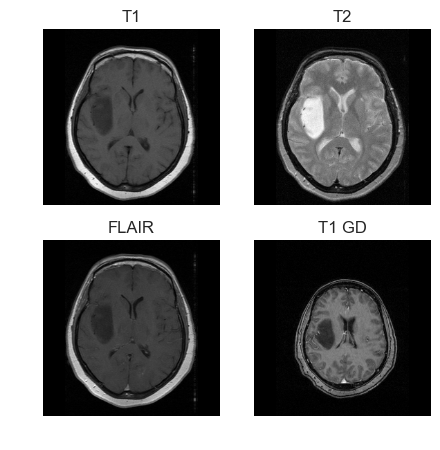

In [40]:
# Define list of images of slice 10 in 4 sequences (2D images)
img_4seq_slice10 = [img_T1_Original[:,:,10], img_T2_Original[:,:,10], 
                    img_FLAIR_Original[:,:,10], img_T1GD_Original[:,:,32]]

sitk_show_4seq(img_4seq_slice10)

In [41]:
# Crop T1 GD image so it is centered similarly to the other sequences - However size is therefore reduced!
crop_up = SimpleITK.CropImageFilter()
crop_up.SetUpperBoundaryCropSize((20,20))
crop_up.SetLowerBoundaryCropSize((40,40))
img_4seq_slice10[3] = crop_up.Execute(img_4seq_slice10[3])
sitk_show_4seq(img_4seq_slice10)

In [42]:
img_4seq_slice10[3].GetSize()

(196, 196)

As we can see T1 GD image doesn't have the same size as the others after cropping. Images are also misaligned so this technique isn't satisfactory.

#### - Second approach: resample filter copying T1 image attributes

In [10]:
# Reinitalise all four images
img_T1_Original = import_img_series(PathDicom_T1)
img_T2_Original = import_img_series(PathDicom_T2)
img_FLAIR_Original = import_img_series(PathDicom_FLAIR)
img_T1GD_Original = import_img_series(PathDicom_T1GD)

In [11]:
# Define resample filter to match T1 image dimension and settings
resample = SimpleITK.ResampleImageFilter()
resample.SetReferenceImage(img_T1_Original)
resample.SetInterpolator(SimpleITK.sitkBSpline)

# Resize all other three images
img_T2_Resized = resample.Execute(img_T2_Original)
img_FLAIR_Resized = resample.Execute(img_FLAIR_Original)
img_T1GD_Resized = resample.Execute(img_T1GD_Original)

# Define list of all 4 resized images
img_4seq_resized = [img_T1_Original, img_T2_Resized, img_FLAIR_Resized, img_T1GD_Resized]

# Define list of images of slice 10 of the 4 sequences (2D images)
img_4seq_slice10 = [img_T1_Original[:,:,10], img_T2_Resized[:,:,10], 
                    img_FLAIR_Resized[:,:,10], img_T1GD_Resized[:,:,10]]

T1
Size: (256, 256, 20)
Origin: (-105.0097885131836, -92.68102264404297, -69.89035034179688)
Spacing: (0.859375, 0.859375, 7.5) 

T2
Size: (256, 256, 20)
Origin: (-105.0097885131836, -92.68102264404297, -69.89035034179688)
Spacing: (0.859375, 0.859375, 7.5) 

FLAIR
Size: (256, 256, 20)
Origin: (-105.0097885131836, -92.68102264404297, -69.89035034179688)
Spacing: (0.859375, 0.859375, 7.5) 

T1 GD
Size: (256, 256, 20)
Origin: (-105.0097885131836, -92.68102264404297, -69.89035034179688)
Spacing: (0.859375, 0.859375, 7.5) 



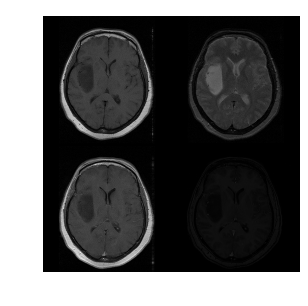

In [12]:
# Show that images are now all aligned

for seq, img in zip(sequence_names, img_4seq_resized):
    print seq
    print 'Size:', img.GetSize()
    print 'Origin:', img.GetOrigin()
    print 'Spacing:', img.GetSpacing(), '\n'
    
sitk_show(SimpleITK.Tile(img_4seq_slice10, (2,2,0)),
         dpi=200)

<a id='Part2b'></a>

### b. Remove noise

/Users/chloe/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


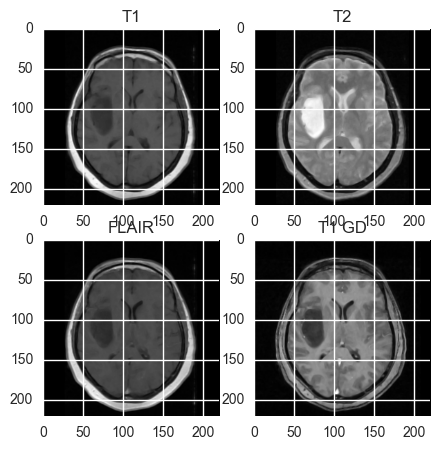

In [13]:
# Apply a curvature-flow filter to smoothen the image (get rid of image noise)

imgSmooth_4seq = []

for img in img_4seq_resized:
    imgSmooth_4seq.append(SimpleITK.CurvatureFlow(image1=img,timeStep=0.125,
                        numberOfIterations=5))

# Define slice 10
imgSmooth_4seq_slice10 = [imgSmooth_4seq[i][:,:,10] for i in range(4)]


sitk_show_4seq(imgSmooth_4seq_slice10, axis='on', size=(5,5))

<a id='Part2c'></a>

### c. Multimodal segmentation - merge T2 and FLAIR images to get a more accurate tumour delimitation

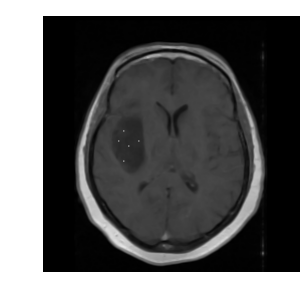

In [14]:
# Find coordinates of points inside tumour on T2 and FLAIR images 
# These will be used as seeds for the VectorConfidenceConnected filter that we will use to isolate the tumour

# Here we maximise pixel values at relevant coordinates so they appear white on the image
# Vary coordinates until all relevant points are found and appear white

lstSeeds = [(80, 115), (75, 125), (85, 130), (80,145), (95,125)]

flair_locs = SimpleITK.Image(imgSmooth_4seq_slice10[2])

for pt in lstSeeds:
    flair_locs[pt[0],pt[1]] = 2000

sitk_show(flair_locs, dpi=100)

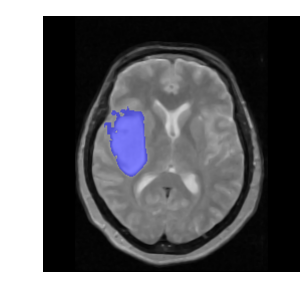

In [15]:
# Merge T2 and FLAIR images
imgComp = SimpleITK.Compose(imgSmooth_4seq_slice10[1], imgSmooth_4seq_slice10[2])

# Compute tumour volume based on newly composed image
imgTumourComp = SimpleITK.VectorConfidenceConnected(image1=imgComp, 
                                               seedList=lstSeeds,
                                               numberOfIterations=3,
                                               multiplier=1.5,
                                               replaceValue=labelTumour)
imgSmoothInt_T2 = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth_4seq_slice10[1]), 
                                           imgTumourComp.GetPixelID())

# Display resulting segmentation on top of composed image
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt_T2, imgTumourComp), dpi=100)

In [16]:
# Get tumour dimensions with this new segmentation

label_shape_analysis_comp = SimpleITK.LabelShapeStatisticsImageFilter()
label_shape_analysis_comp.SetBackgroundValue(0)
label_shape_analysis_comp.Execute(imgTumourComp)

print 'T2 and FLAIR composed image Confidence Connected dimensions'
print 'Centre location:', imgTumourComp.TransformPhysicalPointToIndex(label_shape_analysis_comp.GetCentroid(labelTumour))
print 'Ellipsoid diameters:', label_shape_analysis_comp.GetEquivalentEllipsoidDiameter(labelTumour)
print 'Number of pixels in tumour:', label_shape_analysis_comp.GetNumberOfPixels(labelTumour)

T2 and FLAIR composed image Confidence Connected dimensions
Centre location: (85L, 125L)
Ellipsoid diameters: (31.935668789849387, 57.769490490042365)
Number of pixels in tumour: 1962


<a id='Part3'></a>

## 3. In 3D

In [17]:
def sitk_show_slices(imgs, margin=0.05, dpi=40, axis='off', size=(10,10), first_slice=8, last_slice=14):
    fig, im = plt.subplots(4, last_slice - first_slice +1, figsize=size)
        
    for ax, img, seq in zip([im[0],im[1],im[2],im[3]], imgs, sequence_names):
        for i in range(first_slice, last_slice+1):
            nda = SimpleITK.GetArrayFromImage(img[:,:,i])
            spacing = img[:,:,i].GetSpacing()
            figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
            extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)

            plt.set_cmap("gray")
            ax[i-first_slice].imshow(nda,extent=extent,interpolation=None)
            ax[i-first_slice].set_title(seq+', slice'+str(i))
            ax[i-first_slice].axis(axis)
    
    fig.show()

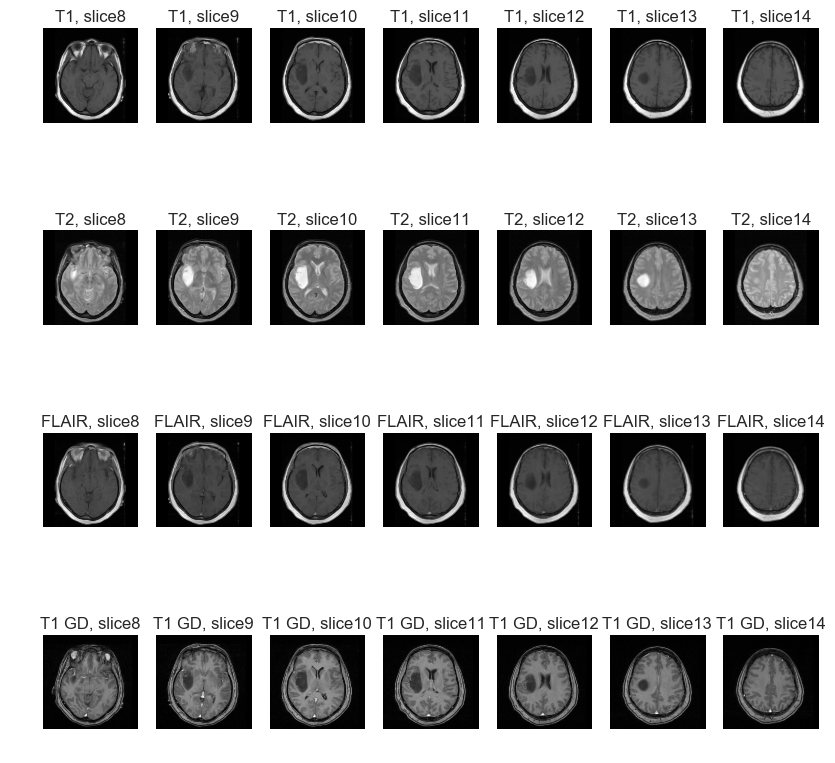

In [18]:
sitk_show_slices(imgSmooth_4seq)

<a id='Part3a'></a>

### a. Segmentation of tumour in each sequence

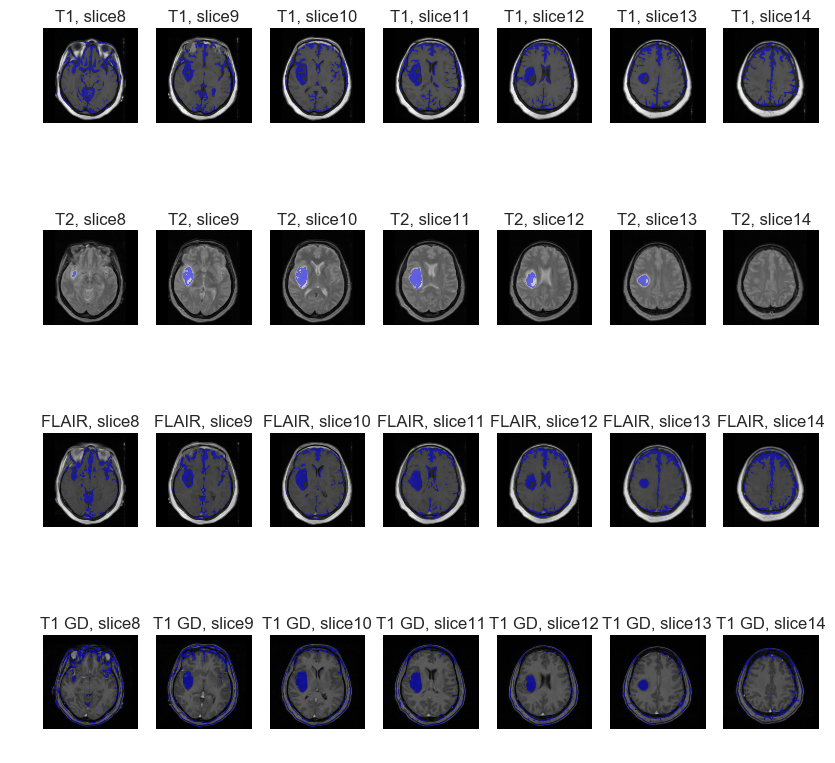

In [19]:
lstSeeds_3D = [(80, 115, 10), (75, 125, 10), (85, 130, 10), (80,145,10), (95,125, 10), 
               (85,130,9), (85,130,11), (85,130,12), (85,130,13)]

imgTumour_perseq = []
imgSmoothInt_4seq = []

for img in imgSmooth_4seq:
    tum = SimpleITK.ConfidenceConnected(image1=img, seedList=lstSeeds_3D, numberOfIterations=3,
                                        multiplier=1.5,replaceValue=labelTumour)
    imgTumour_perseq.append(tum)
    imgSmoothInt_4seq.append(SimpleITK.Cast(SimpleITK.RescaleIntensity(img), tum.GetPixelID()))

sitk_show_slices([SimpleITK.LabelOverlay(i,j) for i,j in zip(imgSmoothInt_4seq, imgTumour_perseq)])

This technique doesn't seem to give good results (unless we finetune the multiplier parameter of each sequence ConfidenceConnected algorithm. Therefore we will try combining the four sequences together instead to get a more accurate tuour segmentation.

<a id='Part3b'></a>

### b. Segmentation of tumour in all four sequences combined

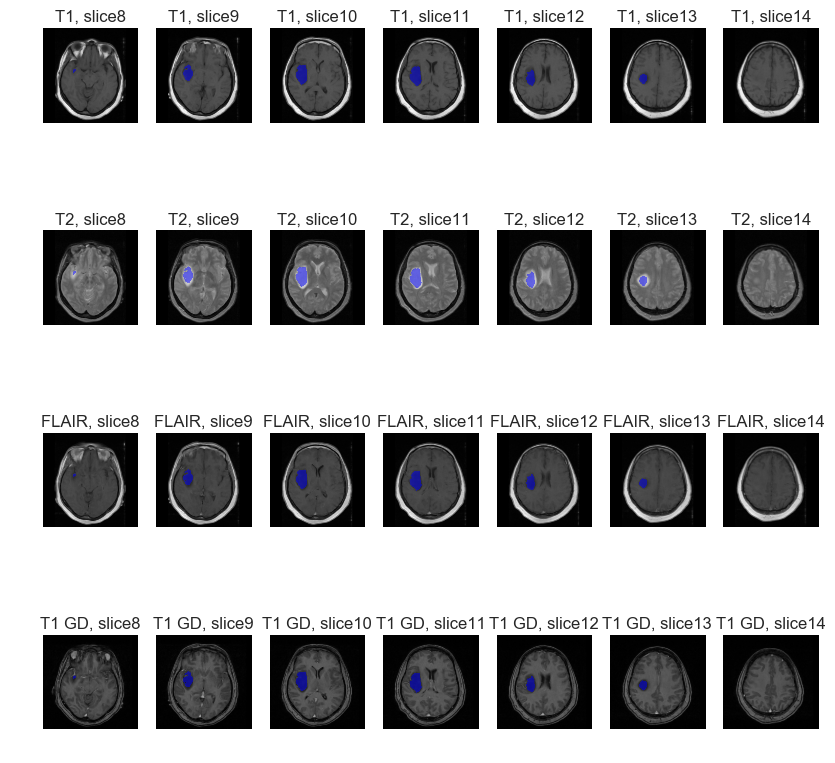

In [85]:
# Merge the four images
imgCompAll = SimpleITK.Compose(imgSmooth_4seq[0], imgSmooth_4seq[1], imgSmooth_4seq[2], imgSmooth_4seq[3])

# Compute tumour volume based on newly composed image
imgTumourCompAll = SimpleITK.VectorConfidenceConnected(image1=imgCompAll, 
                                                       seedList=lstSeeds_3D,
                                                       numberOfIterations=3,
                                                       multiplier=1.5,
                                                       replaceValue=labelTumour)

imgSmoothInt_4seq = []
for img in imgSmooth_4seq:
    imgSmoothInt_4seq.append(SimpleITK.Cast(SimpleITK.RescaleIntensity(img), imgTumourComp3D.GetPixelID()))


sitk_show_slices([SimpleITK.LabelOverlay(i, imgTumourCompAll) for i in imgSmoothInt_4seq])

This technique seems to give a proper segmentation of the tumour accross all 4 sequences and 7 slices.   
We would still need to isolate the tumour on each sequence separately as the differences in size and contrasts between sequences are relevant features for tumour characterisation but this could be used to compute all the geometric properties of the tumour. (Or even to select the slice which contains the largest tumour diameter on which we can then conduct the rest of the analysis and extract the relevant features).

<a id='Part3c'></a>

### c. Segmentation of tumour in T2 and FLAIR images combined

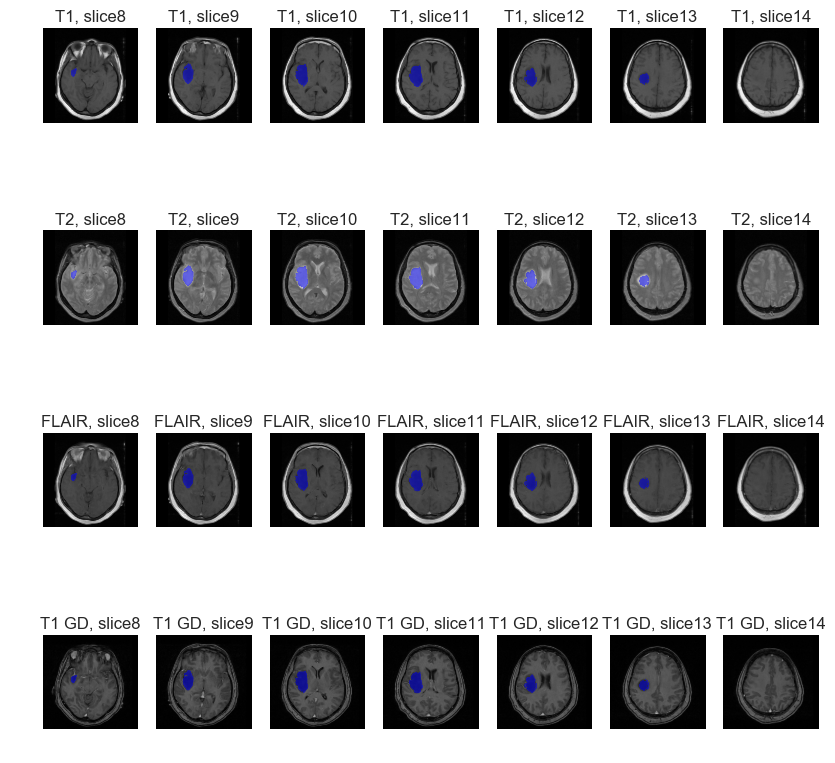

In [86]:
# Merge T2 and FLAIR images
imgComp3D = SimpleITK.Compose(imgSmooth_4seq[1], imgSmooth_4seq[2])

# Compute tumour volume based on newly composed image
imgTumourComp3D = SimpleITK.VectorConfidenceConnected(image1=imgComp3D, 
                                                       seedList=lstSeeds_3D,
                                                       numberOfIterations=3,
                                                       multiplier=1.5,
                                                       replaceValue=labelTumour)

imgSmoothInt_4seq = []
for img in imgSmooth_4seq:
    imgSmoothInt_4seq.append(SimpleITK.Cast(SimpleITK.RescaleIntensity(img), imgTumourComp3D.GetPixelID()))


sitk_show_slices([SimpleITK.LabelOverlay(i, imgTumourComp3D) for i in imgSmoothInt_4seq])

As mentionned in paper **(?????)** tumour segmentation seems to be more accurate when merging only T2 and FLAIR images.

<a id='Part3d'></a>

### d. Automate seed generation

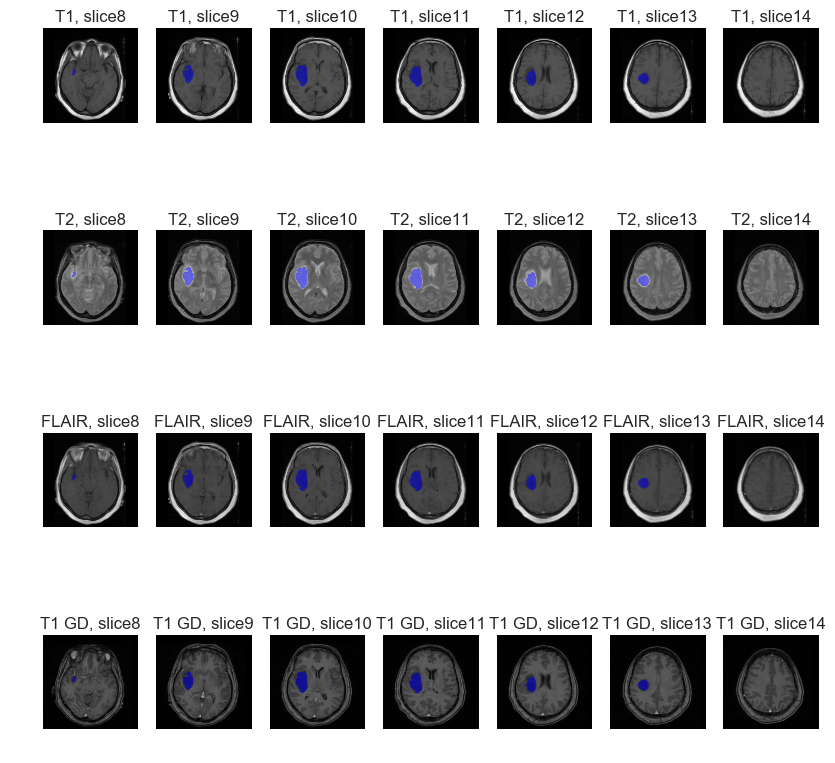

In [102]:
# Tumour segmentation with Binary Thresholding on T2 imaging - to automate feature extraction

tumour_thres_3D = SimpleITK.BinaryThreshold(imgSmooth_4seq[1], lowerThreshold=700, upperThreshold=900, 
                                            insideValue=labelTumour, outsideValue=0)

sitk_show_slices([SimpleITK.LabelOverlay(i, tumour_thres_3D) for i in imgSmoothInt_4seq])

In [145]:
# Generate seeds thresholding segmentation
seeds_auto_3D_array = np.argwhere(SimpleITK.GetArrayFromImage(tumour_thres_3D)==2)

# We manually excluded slices from 1 to 8 as the filter was isolating other fluids in these slices
seeds_auto_3D_array = [seeds_auto_3D_array[i] for i in np.where(seeds_auto_3D_array[:,0]>8)]

# Inverse dimensions as the function GetArryFromImage returns vertical image values in lines and horizontal image values in columns 
seeds_auto_3D = []
for seed in seeds_auto_3D_array[0]:
    seeds_auto_3D.append((seed[2], seed[1], seed[0]))

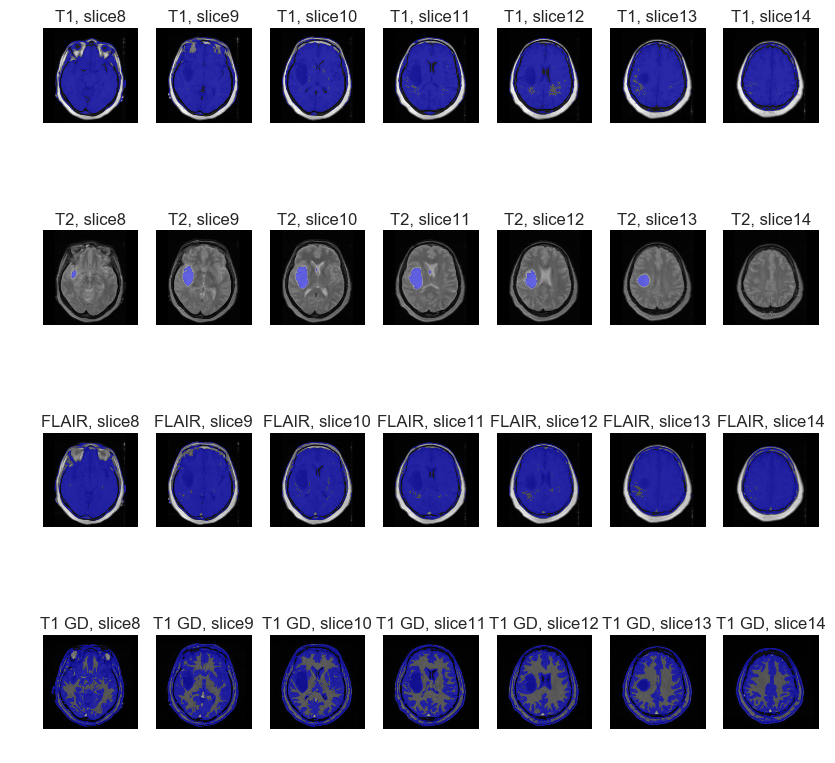

In [147]:
# Segmentation of tumour in each sequence with automatically generated seeds

imgTumour_perseq = []
imgSmoothInt_4seq = []

for img in imgSmooth_4seq:
    tum = SimpleITK.ConfidenceConnected(image1=img, seedList=seeds_auto_3D, numberOfIterations=3,
                                        multiplier=1.5, replaceValue=labelTumour)
    imgTumour_perseq.append(tum)
    imgSmoothInt_4seq.append(SimpleITK.Cast(SimpleITK.RescaleIntensity(img), tum.GetPixelID()))

sitk_show_slices([SimpleITK.LabelOverlay(i,j) for i,j in zip(imgSmoothInt_4seq, imgTumour_perseq)])

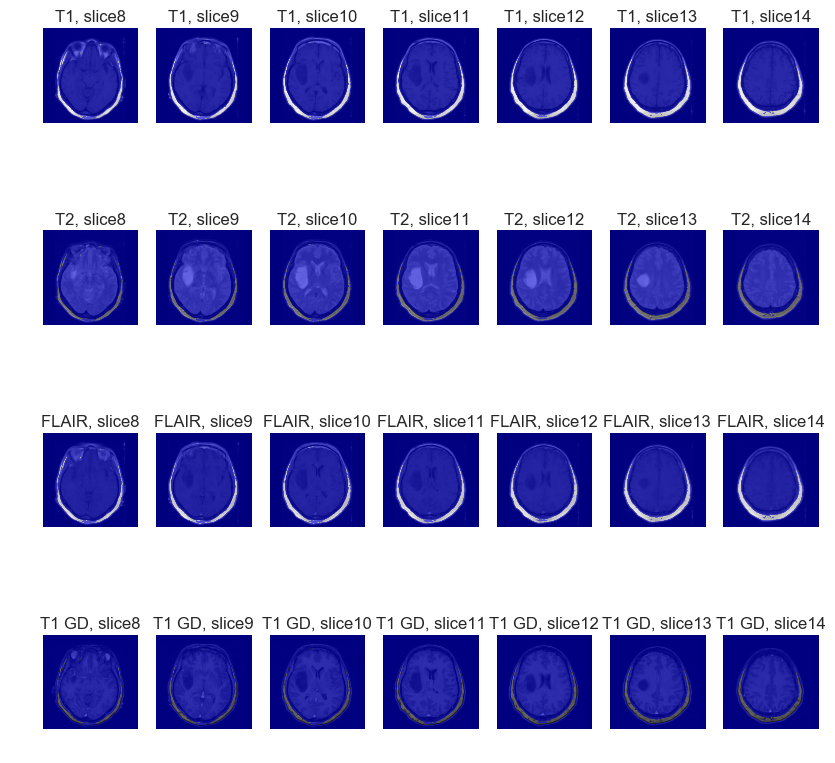

In [148]:
# Segmentation of tumour T2 and FLAIR sequences in 3D - with automatically generated seeds

# Merge the T2 and FLAIR
imgComp3D = SimpleITK.Compose(imgSmooth_4seq[1], imgSmooth_4seq[2])

# Compute tumour volume based on newly composed image
imgTumourComp3D = SimpleITK.VectorConfidenceConnected(image1=imgComp3D, 
                                                       seedList=seeds_auto_3D,
                                                       numberOfIterations=3,
                                                       multiplier=1.5,
                                                       replaceValue=labelTumour)

imgSmoothInt_4seq = []
for img in imgSmooth_4seq:
    imgSmoothInt_4seq.append(SimpleITK.Cast(SimpleITK.RescaleIntensity(img), imgTumourComp3D.GetPixelID()))


sitk_show_slices([SimpleITK.LabelOverlay(i, imgTumourComp3D) for i in imgSmoothInt_4seq])

This technique seems much more difficult to implement than in 2D and we do not necessarily need all slices calculate the VASARI features. Therefore, in the interest of time we will only use the 3D images to select the slice where the tumour area is maximised and then complete our analysis and feature extraction in 2D.

<a id='Part3e'></a>

### e. Selection of slice with largest tumour area

In [156]:
# We will base our selection on the tumour isolated in 3D with thresholding

# Define initial slice to start looking for tumour
slice_max = 9

# Compute number of pixels in tumour in this slice
label_shape_analysis_thres_3D = SimpleITK.LabelShapeStatisticsImageFilter()
label_shape_analysis_thres_3D.SetBackgroundValue(0)
label_shape_analysis_thres_3D.Execute(tumour_thres_3D[:,:,9])

slice_pixels = label_shape_analysis_thres_3D.GetNumberOfPixels(labelTumour)

# Loop through the rest of the slices and assign the slice with largest tumour area to slice_max
for s in range(10, 20):
    if np.count_nonzero(SimpleITK.GetArrayFromImage(tumour_thres_3D[:,:,s])) > 0: #check that tumour was detected in slice
        label_shape_analysis_thres_3D.Execute(tumour_thres_3D[:,:,s])
        pix = label_shape_analysis_thres_3D.GetNumberOfPixels(labelTumour)
        if pix > slice_pixels:
            (slice_max, slice_pixels) = (s, pix)

print 'Selected slice:', slice_max

Selected slice: 10
